*$$\textbf{TP 4 : Improve the Metropolis-Hastings algorithm}$$*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, invgamma

import pandas as pd
import random
from tqdm import tqdm
import copy

# 1.A – Metropolis-Hastings within Gibbs sampler

In [2]:
def log_target_density(x,y,a=10):
    'log of the pi density we want to sample from'
    x_squared = np.square(x)
    y_squared = np.square(y)
    return -x_squared/a**2 - y_squared - (x_squared/a**2 - y_squared)**2

def target_density(x,y,a=10):
    'pi density we want to sample from'
    return np.exp(log_target_density(x,y,a))

## Q-1

As in the course, we sample $P_{1}(z; ·)$ and $P_{2}(z; ·)$ using G-SRWHM : 

In [3]:
def sample_P_x(x, y, sigma_x, target_density, x_acceptance):
    x_prime = np.random.normal(x, sigma_x**2)
    y_prime = y
    u = np.random.uniform()
    acceptance_rate = np.min([1.0, target_density(x_prime, y_prime) / target_density(x, y)])
    x_acceptance.append(acceptance_rate)
    if u < acceptance_rate: #we accept the proposal
        return x_prime, y_prime
    else: #we reject the proposal and return (x,y)
        return x,y

def sample_P_y(x, y, sigma_y, target_density, y_acceptance):
    x_prime = x
    y_prime = np.random.normal(y, sigma_y**2)
    u = np.random.uniform()
    acceptance_rate = np.min([1.0, target_density(x_prime, y_prime) / target_density(x, y)])
    y_acceptance.append(acceptance_rate)

    if u < acceptance_rate:
        return x_prime, y_prime
    else : 
        return x,y

In [4]:
def Gibbs_with_GSRWHM(x0, y0, sigma_x, sigma_y, target_density, N_iter):
    x = x0
    y = y0
    liste_samples = [[x0, y0]]
    x_acceptance = []
    y_acceptance = []
    
    for i in tqdm(range(N_iter)):
        u = np.random.uniform()
        if u<0.5:
            #we update x
            x, y = sample_P_x(x, y, sigma_x, target_density, x_acceptance)
        else :
            #we update y
            x, y = sample_P_y(x, y, sigma_y, target_density, y_acceptance)
        liste_samples.append([x,y])
    return liste_samples, x_acceptance, y_acceptance

## Q-2

In [50]:
sigma_x, sigma_y = 3, 3
x0, y0 = np.random.normal(0, 1), np.random.normal(0, 1)
N_iter = 20000

res = Gibbs_with_GSRWHM(x0, y0, sigma_x, sigma_y, target_density, N_iter)
samples = res[0]
x_acceptance_rate = res[1]
y_acceptance_rate = res[2]

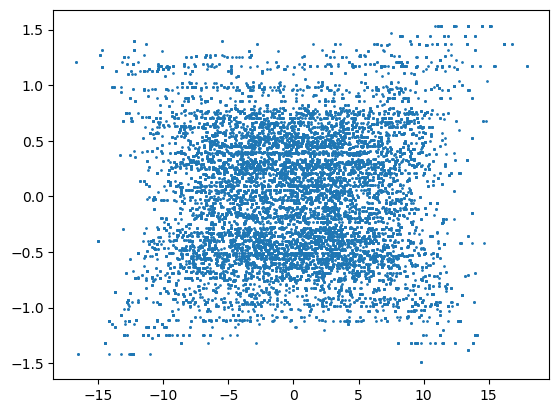

In [51]:
# Plot the samples
samples = np.array(samples)
plt.scatter(samples[:,0], samples[:,1], s=1)
plt.show()

Text(0.5, 1.0, 'Trajectory of the MC for the second coordinate')

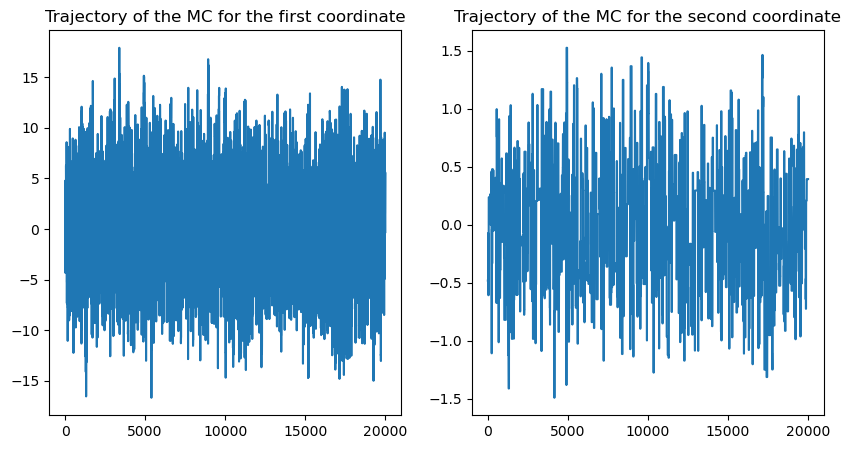

In [52]:
# Trajectory of the coordinates
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(samples[:,0], label='First coordinate')
axes[0].set_title('Trajectory of the MC for the first coordinate')
axes[1].plot(samples[:,1], label='Second coordinate')
axes[1].set_title('Trajectory of the MC for the second coordinate')


In [5]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

Text(0.5, 1.0, 'Moving average of the acceptance rate for the second coordinate')

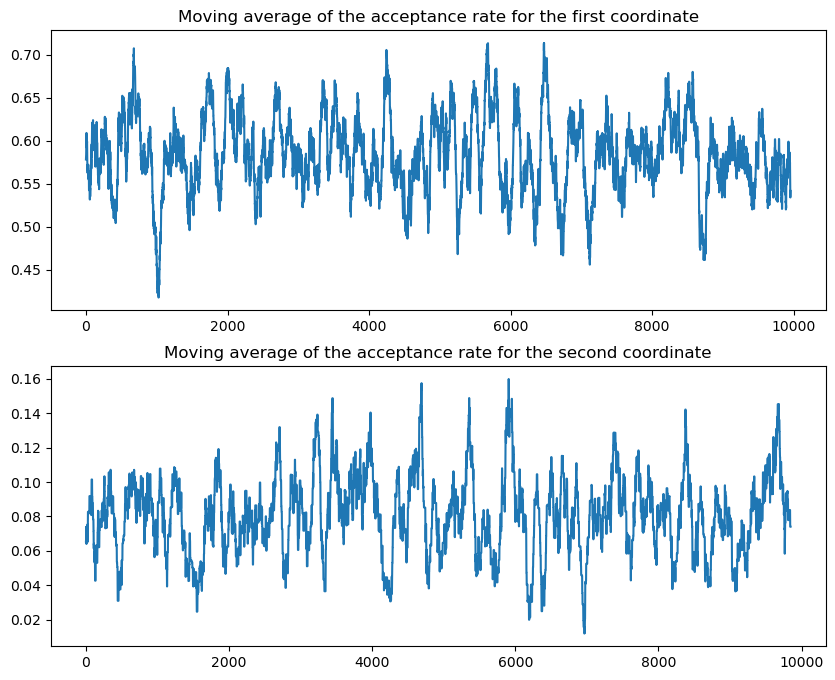

In [54]:
# Moving average acceptance rates plot
fig, axes = plt.subplots(2,1, figsize=(10,8))
axes[0].plot(moving_average(x_acceptance_rate, 100), label='First coordinate')
axes[0].set_title('Moving average of the acceptance rate for the first coordinate')
axes[1].plot(moving_average(y_acceptance_rate, 100), label='Second coordinate')
axes[1].set_title('Moving average of the acceptance rate for the second coordinate')

The target distribution being anysotropic, fixing $\sigma_{1} = \sigma_{2}$ is not smart at all. The first graph shows that the variance on the first coordinated is more important than the variance on the second coordinates. The proposed kernel's $\sigma_1$ is too small compared to the variance of the first coordinate. This leads to the first coordinates is far more often accepted than the second (see above graphs). Moreover, we know that the optimal acceptance rate should be $\sim$ 0.24 ; $\textbf{the first coordinate's acceptance ratio is too high, and the second coordinate's acceptance ratio is too low}$

(0.0, 150.0)

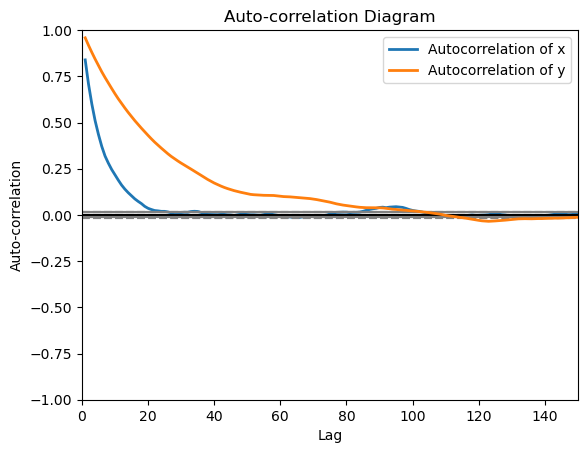

In [55]:
# plot autocorrelation

pd.plotting.autocorrelation_plot(samples[:,0], label='Autocorrelation of x',linewidth=2)
pd.plotting.autocorrelation_plot(samples[:,1], label = 'Autocorrelation of y',linewidth=2)
plt.title('Auto-correlation Diagram')
plt.xlabel('Lag')
plt.ylabel('Auto-correlation')
plt.legend()
plt.xlim((0,150))

The acceptance rate for y being too low, the algorithm has trouble dealing with the y coordinates (autocorrelation does not tend towards 0). 

## Q-3

To improve the performances of the above algorithm, one could try 2 methods : 
- Keep the $\sigma_i$ fixed, but try to fine tune their value beforehand (manually or by using a grid search). 
- Use adaptive MCMC algorithms to update the parameters of the proposed kernel (the $\sigma_i$) during the iterations. 

# 1.B - Adaptive Metropolis-Hastings within Gibbs sampler

## Q-1

In [6]:
def sample_P(x, sigma, target_density, acceptance):
    'Parameters : '
    'x is in R^d'
    'sigma is a d-dimensional vector, with sigma[i] the variance of the ith coordinate'
    'target_density is the density we want to sample from'
    'acceptance rate is a list that will store the acceptance rate of the algorithm, for each coordinate'
    d = len(x)
    for coordinate in range(d):
        proposal = np.copy(x)
        random_vector = np.random.uniform(0,1,d)
        proposal[coordinate] += np.random.normal(0, sigma[coordinate]**2)
        acceptance_rate = np.min([1.0, target_density(proposal) / target_density(x)])
        acceptance[coordinate].append(acceptance_rate)

        if random_vector[coordinate] < acceptance_rate: #we accept the proposal
            x = proposal
    return x 

In [7]:
def Adaptive_Gibbs_with_GSRWHM(x, sigma, target_density, N_iter):
    'Parameters : '
    'x is in R^d'
    'sigma is a d-dimensional vector, with sigma[i] the variance of the ith coordinate'
    'target_density is the density we want to sample from'
    'N_iter is the number of iterations of the algorithm'

    'Returns : '
    'a list of samples of the Markov Chain'
    'a list of the acceptance rate of the algorithm for each coordinate'

    liste_samples = [x]
    l = np.log(sigma)
    j=0
    acceptance = [[] for i in range(len(x))]
    
    for i in tqdm(range(N_iter)):
        if j+1 % 50 == 0: #every 50 iterations, we update the variance of the proposal distribution
            for k in range(len(x0)):
                if np.mean(acceptance[k][-7:]) > 0.234:
                    delta = min(0.01, 1/np.sqrt(j))
                    l[k] += delta
                    sigma[k] = np.exp(l[k])
                elif np.mean(acceptance[k][-7:]) < 0.234:
                    delta = min(0.01, 1/np.sqrt(j))
                    l[k] -= delta
                    sigma[k] = np.exp(l[k])

        x = sample_P(x, sigma, target_density, acceptance) #update the Markov Chain
        liste_samples.append(x)
        j+=1

    return liste_samples, acceptance

In [8]:
# Need to quickly redefine the target density function to take only one argument

def log_pi_density(x,a=10):
    'log of the pi density we want to sample from'
    return log_target_density(x[0], x[1], a)

def pi_density(x,a=10):
    'pi density we want to sample from'
    return np.exp(log_pi_density(x,a))

In [73]:
sigma = [1.0, 1.0]
x0 = np.random.normal(0, 1, 2)
N_iter = 50000

res = Adaptive_Gibbs_with_GSRWHM(x0, sigma, pi_density, N_iter)

samples = res[0]
acceptance_rates = res[1]

Text(0.5, 1.0, 'Moving average of the acceptance rate for the second coordinate')

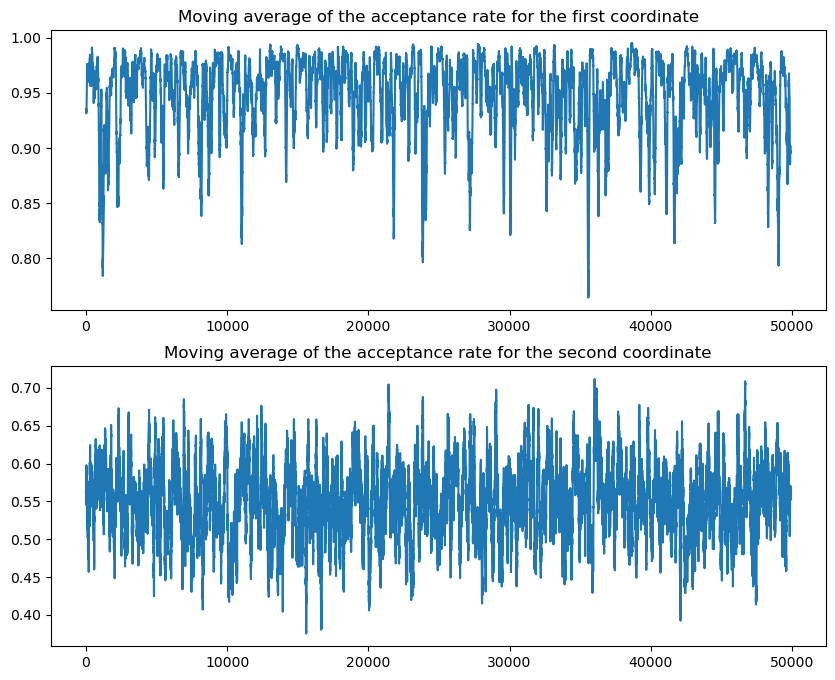

In [74]:
# Moving average acceptance rates plot
fig, axes = plt.subplots(2,1, figsize=(10,8))
axes[0].plot(moving_average(acceptance_rates[0], 100), label='First coordinate')
axes[0].set_title('Moving average of the acceptance rate for the first coordinate')
axes[1].plot(moving_average(acceptance_rates[1], 100), label='Second coordinate')
axes[1].set_title('Moving average of the acceptance rate for the second coordinate')

(0.0, 200.0)

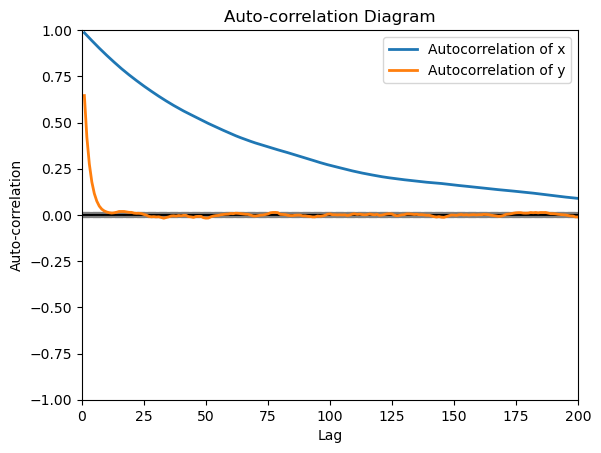

In [75]:
# plot autocorrelation
pd.plotting.autocorrelation_plot(np.array(samples)[:,0], label='Autocorrelation of x',linewidth=2)
pd.plotting.autocorrelation_plot(np.array(samples)[:,1], label = 'Autocorrelation of y',linewidth=2)
plt.title('Auto-correlation Diagram')
plt.xlabel('Lag')
plt.ylabel('Auto-correlation')
plt.legend()
plt.xlim((0,200))

### Variante : modifying $\sigma_x$

It looks like the algorithm has fixed the issues we encountered on y. However, the autocorrelation plot for x is disastrous. I tried to run the algorithm with a different initial value for $\sigma_x$ (=5), which is closer to the variance we observe on the MC's path.

(0.0, 200.0)

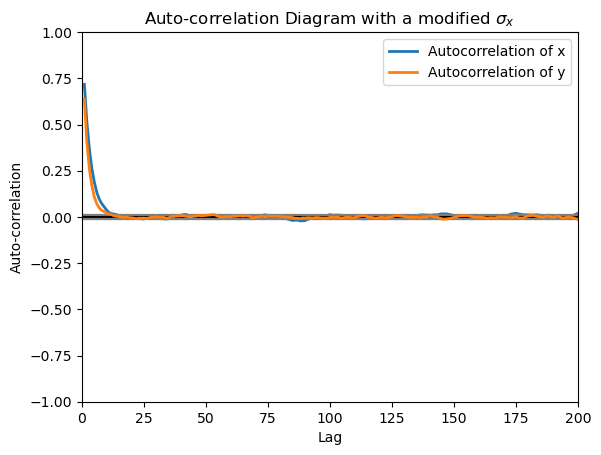

In [76]:
# Variante 

sigma = [5.0, 1.0]
x0 = np.random.normal(0, 1, 2)
N_iter = 50000

res = Adaptive_Gibbs_with_GSRWHM(x0, sigma, pi_density, N_iter)

samples = res[0]
acceptance_rates = res[1]
x_acceptance_rate = acceptance_rates[0]
y_acceptance_rate = acceptance_rates[1]

# plot autocorrelation
pd.plotting.autocorrelation_plot(np.array(samples)[:,0], label='Autocorrelation of x',linewidth=2)
pd.plotting.autocorrelation_plot(np.array(samples)[:,1], label = 'Autocorrelation of y',linewidth=2)
plt.title('Auto-correlation Diagram with a modified $\sigma_x$')
plt.xlabel('Lag')
plt.ylabel('Auto-correlation')
plt.legend()
plt.xlim((0,200))

The results are much better, for both x and y. The adaptive algorithm outperforms the classical HM-Gibbs one. 

Text(0.5, 1.0, 'Moving average of the acceptance rate for the second coordinate')

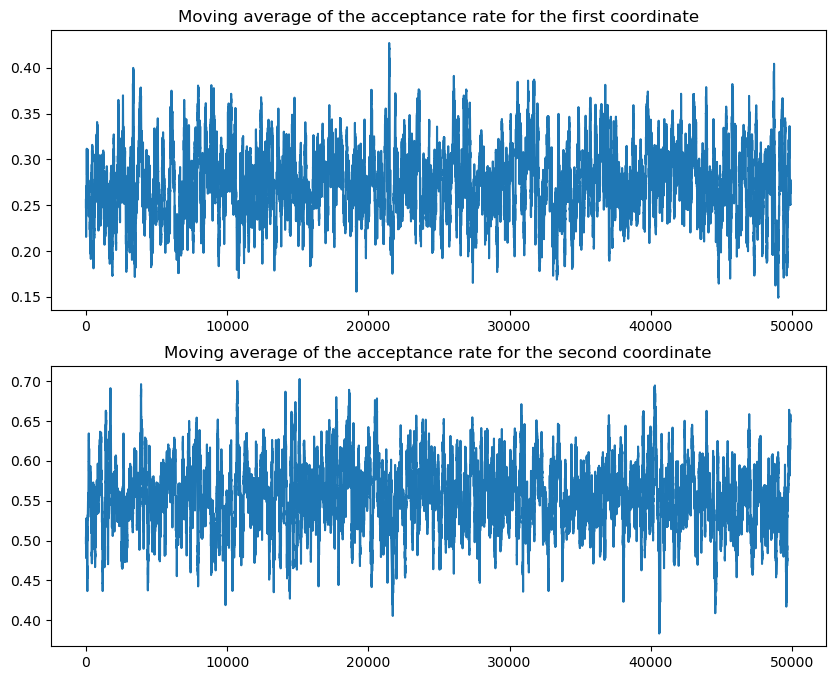

In [77]:
# Moving average acceptance rates plot
fig, axes = plt.subplots(2,1, figsize=(10,8))
axes[0].plot(moving_average(acceptance_rates[0], 100), label='First coordinate')
axes[0].set_title('Moving average of the acceptance rate for the first coordinate')
axes[1].plot(moving_average(acceptance_rates[1], 100), label='Second coordinate')
axes[1].set_title('Moving average of the acceptance rate for the second coordinate')

By the way, the acceptance rates are closer to the optimal one (0.23) ! 

## Q-2 : Banana shaped densities

In [9]:
def log_banana_target(x, B=0.1):
    'Target density: banana distribution'
    x_squared = np.square(x)
    sum_squared = np.sum(x_squared)
    res = - np.square(x[0])/200 - 0.5 * np.square(x[1] +B*np.square(x[0]) - 100*B) - 1/2 * sum_squared
    return res

def banana_target(x, B=0.1):
    'Target density: banana distribution'
    return np.exp(log_banana_target(x, B))

In [86]:
d = 20
B = 0.1

sigma0 = np.ones(d)
x0 = np.random.normal(0, 1, d)
N_iter = 50000

res = Adaptive_Gibbs_with_GSRWHM(x0, sigma0, banana_target, N_iter)
samples = res[0]
acceptance_rate = res[1]

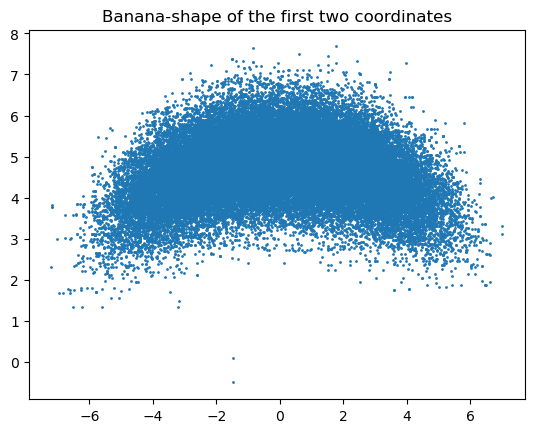

In [88]:
# scatter plot of the first two coordinates
samples = np.array(samples)
plt.scatter(samples[:,0], samples[:,1], s=1)
plt.title('Banana-shape of the first two coordinates')
plt.show()

Our algorithm seems to perform pretty well. Especially, it is much faster than the EM-based one we implemented in TP2 ! 

(0.0, 200.0)

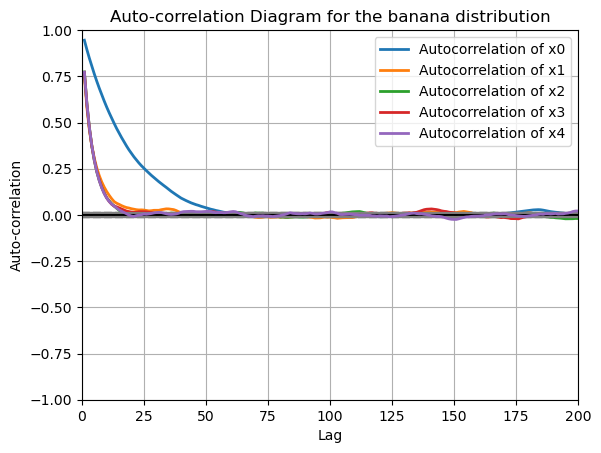

In [80]:
# autocorrelation plot
for i in range(d):
    pd.plotting.autocorrelation_plot(np.array(samples)[:,i], label='Autocorrelation of x'+str(i),linewidth=2)
plt.title('Auto-correlation Diagram for the banana distribution')
plt.xlabel('Lag')
plt.ylabel('Auto-correlation')
plt.legend()
plt.xlim((0,200))


Autocorrelations decay rapidly, appart from the first coordinate.

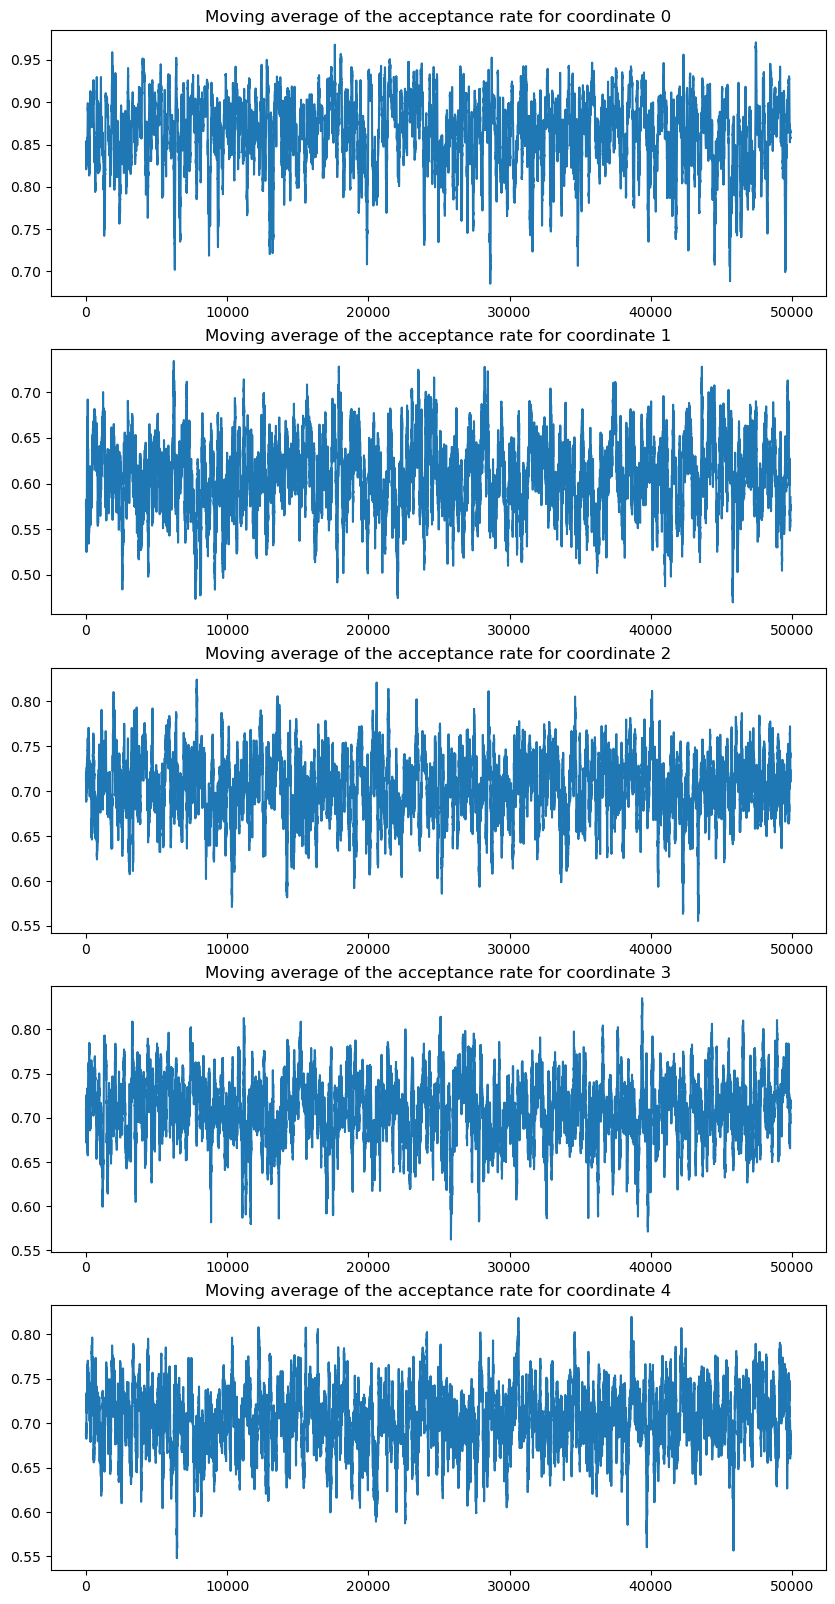

In [84]:
# Moving average acceptance rates plot
fig, axes = plt.subplots(d,1, figsize=(10,20))
for i in range(d):
    axes[i].plot(moving_average(acceptance_rate[i], 100), label='Coordinate '+str(i))
    axes[i].set_title('Moving average of the acceptance rate for coordinate '+str(i))

Acceptance rate are perhaps still a little bit too high. 

# 2.A - Toy example with GMMs

## Q-1

We know how to directly sample from $\pi$ : 

In [10]:
def sample_discrete_distribution(liste_pi, liste_xi, n_samples):
    'Produces n_samples samples from a discrete distribution'
    'given the list of probabilities liste_pi and the list of values liste_xi'
    
    cumul_liste_pi = np.cumsum(liste_pi)
    uniform_samples = np.random.uniform(0, 1, n_samples)
    samples = []
    for u in uniform_samples:
        index = np.searchsorted(cumul_liste_pi, u)
        samples.append(liste_xi[index])
    return samples

def samples_GMM(n_samples, liste_pi, liste_mu, liste_sigma):
    'Sample n_samples from a Gaussian Mixture Model'
    clusters = np.array([np.random.choice(len(liste_pi), p=liste_pi) for _ in range(n_samples)])
    samples = []
    for cluster in clusters:
        samples.append(np.random.multivariate_normal(liste_mu[cluster], liste_sigma[cluster]))
    samples = np.array(samples)
    return samples, clusters

In [11]:
n_cluster = 20
n_samples = 10000

weights = [0.05 for i in range(20)]
cov = [0.1*np.eye(2) for i in range(20)]

mus = [(2.18, 5.76), (8.67, 9.59), (4.24, 8.48), (8.41, 1.68), (3.93, 8.82),
    (3.25, 3.47), (1.70, 0.50), (4.59, 5.60), (6.91, 5.81), (6.87, 5.40),
    (5.41, 2.65), (2.70, 7.88), (4.98, 3.70), (1.14, 2.39), (8.33, 9.50),
    (4.93, 1.50), (1.83, 0.09), (2.26, 0.31), (5.54, 6.86), (1.69, 8.11)]

res_true_distrib = samples_GMM(n_samples, weights, mus, cov)

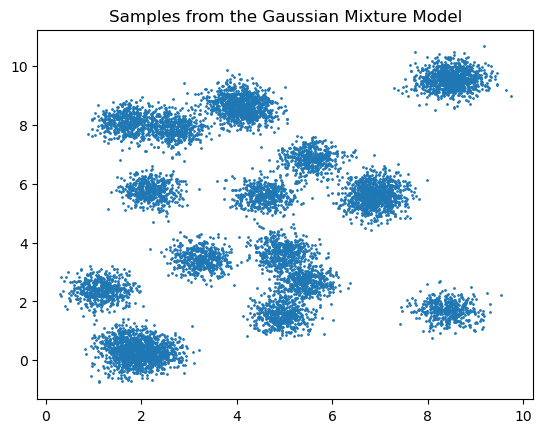

In [17]:
samples_true_distrib = res_true_distrib[0]
plt.scatter(samples_true_distrib[:,0], samples_true_distrib[:,1], s=1)
plt.title('Samples from the Gaussian Mixture Model')
plt.show()

## Q-2 

We can try to use the Adaptive MH Gibbs sampler to sample from the pi distribution : 

In [18]:
def GMM_density(x, theta = [weights, mus, cov]):
    'GMM density in x'
    'Theta contains the parameters of the GMM model : pi, mu, sigma'
    pi, mu, sigma = theta[0], theta[1], theta[2]
    density = 0
    for k in range(len(pi)):
        density += pi[k] * multivariate_normal.pdf(x, mean=mu[k], cov=sigma[k])
    return density

In [19]:
d = 2

sigma0 = np.ones(d)
x0 = np.random.normal(0, 10, d)
N_iter = 50000

res = Adaptive_Gibbs_with_GSRWHM(x0, sigma0, GMM_density, N_iter)
samples = res[0]
acceptance_rate = res[1]

100%|██████████| 50000/50000 [02:14<00:00, 372.28it/s]


Text(0.5, 1.0, 'Samples from the Gaussian Mixture Model')

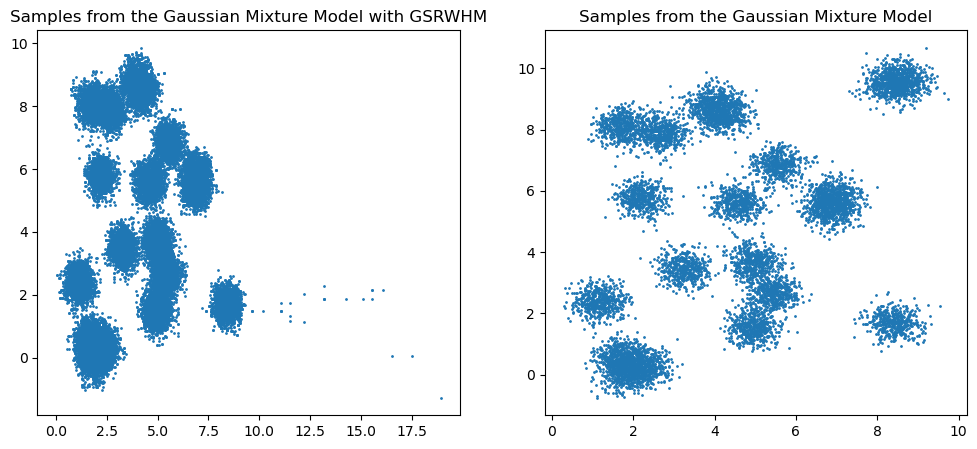

In [20]:
samples = np.array(samples)
fig, axes = plt.subplots(1,2, figsize=(12,5))

axes[0].scatter(samples[:,0], samples[:,1], s=1)
axes[0].set_title('Samples from the Gaussian Mixture Model with GSRWHM')
axes[1].scatter(samples_true_distrib[:,0], samples_true_distrib[:,1], s=1)
axes[1].set_title('Samples from the Gaussian Mixture Model')

Several remarks : 
- The algorithm is long to run, since with a 20-clusters GMM density, calculating the acceptance ratio at each iteration takes a lot of computing power
- $\textbf{The algorithm fails to explore all the modes of the distribution}$ !! This is a classical flaw of the MCMC Gibbs samplers ! We can clearly see that the more isolated clusters are practically not explored at all by the sampler. Only 13 out of the 20 clusters are explored by the algorithm. 

# 2.B - Parallel Tempering

## Q-1

In [35]:
def choose_uniform_pair(K):
    'Choose a pair of integers uniformly between 0 and K-1, with a difference of 1'
    valid_pairs = [(i, j) for i in range(K) for j in range(K) if abs(i - j) == 1]
    return random.choice(valid_pairs)

def tempered_GMM_density(x, temperature):
    return GMM_density(x)**(1/temperature)

def HM_Gaussian_kernel(x,tau, temperature):
    proposed_x = x + np.random.normal(size=len(x))*tau
    alpha = min(1, tempered_GMM_density(proposed_x, temperature) / tempered_GMM_density(x, temperature))
    u=np.random.rand()
    if  u < alpha: 
        return proposed_x,1
    else: 
        return x,0

In [36]:
def parallel_tempering_MCMC(x, N_iter, temperatures):
    'Parameters : '
    'x is is a matrix of size N_chains x d'
    'target_density is the density we want to sample from'
    'N_iter is the number of iterations per sweep'
    'temperatures is a list of the temperatures of the chains'

    'Remark : Adaptive parallel tempering is not implemented here'

    'Returns : '
    'a list of samples of the Markov Chain'

    K=len(temperatures)
    samples = [x]
    acceptance_list=np.zeros((N_iter,K))
    tau=0.25*np.sqrt(temperatures)
    
    new_x=x

    for i in tqdm(range(1, N_iter)):
        current_x= samples[-1]
        # computation of Y proposals
        for temp in range(K):
            new_x[temp],accept= HM_Gaussian_kernel(current_x[temp],tau[temp], temperatures[temp])
            acceptance_list[i,temp]=accept
        # Swap step
        (idx_i,idx_j)=choose_uniform_pair(K)
        swap_acceptance_ratio=min(1,\
            (tempered_GMM_density(new_x[idx_j], temperatures[idx_i])* \
             tempered_GMM_density(new_x[idx_i], temperatures[idx_j]))/ \
            (tempered_GMM_density(new_x[idx_i], temperatures[idx_i])* \
             tempered_GMM_density(new_x[idx_j], temperatures[idx_j])) )
        
        u=np.random.rand()

        if u < swap_acceptance_ratio:
            temporary=new_x[idx_i]
            new_x[idx_i]=new_x[idx_j]
            new_x[idx_j]=temporary

        samples.append(np.copy(new_x))
            
    return np.array(samples), acceptance_list

## Q-2

In [37]:
temperatures = [60, 21.6, 7.7, 2.8, 1.0]
taus = 0.25 * np.sqrt(temperatures) 

N_chains = 5
x0 = np.ones((N_chains, d))
N_iter = 20000

samples = parallel_tempering_MCMC(x0, N_iter, temperatures)

100%|██████████| 19999/19999 [03:12<00:00, 103.93it/s]


In [45]:
MCchains = samples[0]
acceptance_rates = samples[1]

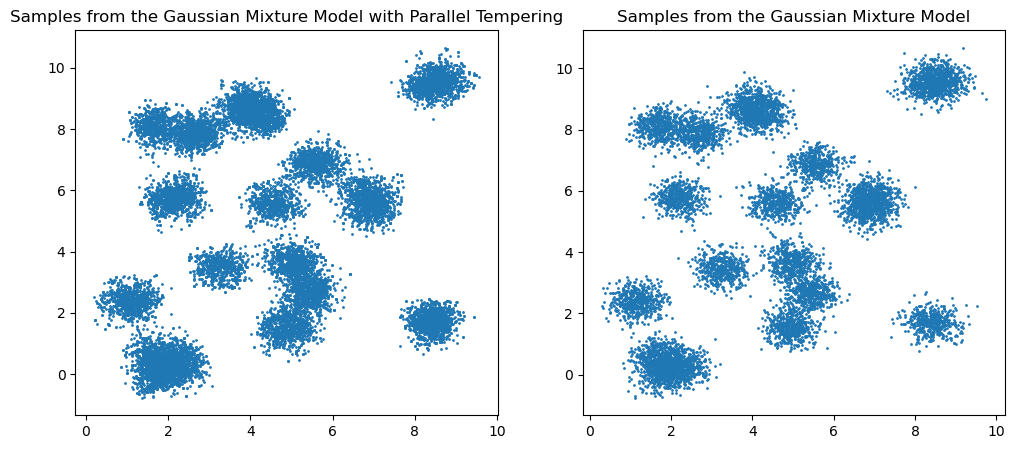

In [46]:
target_distrib_samples = np.array([x[-1] for x in MCchains])
fig, axes = plt.subplots(1,2, figsize=(12,5))

axes[0].scatter(target_distrib_samples[:,0], target_distrib_samples[:,1], s=1)
axes[0].set_title('Samples from the Gaussian Mixture Model with Parallel Tempering')
axes[1].scatter(samples_true_distrib[:,0], samples_true_distrib[:,1], s=1)
axes[1].set_title('Samples from the Gaussian Mixture Model')
plt.show()

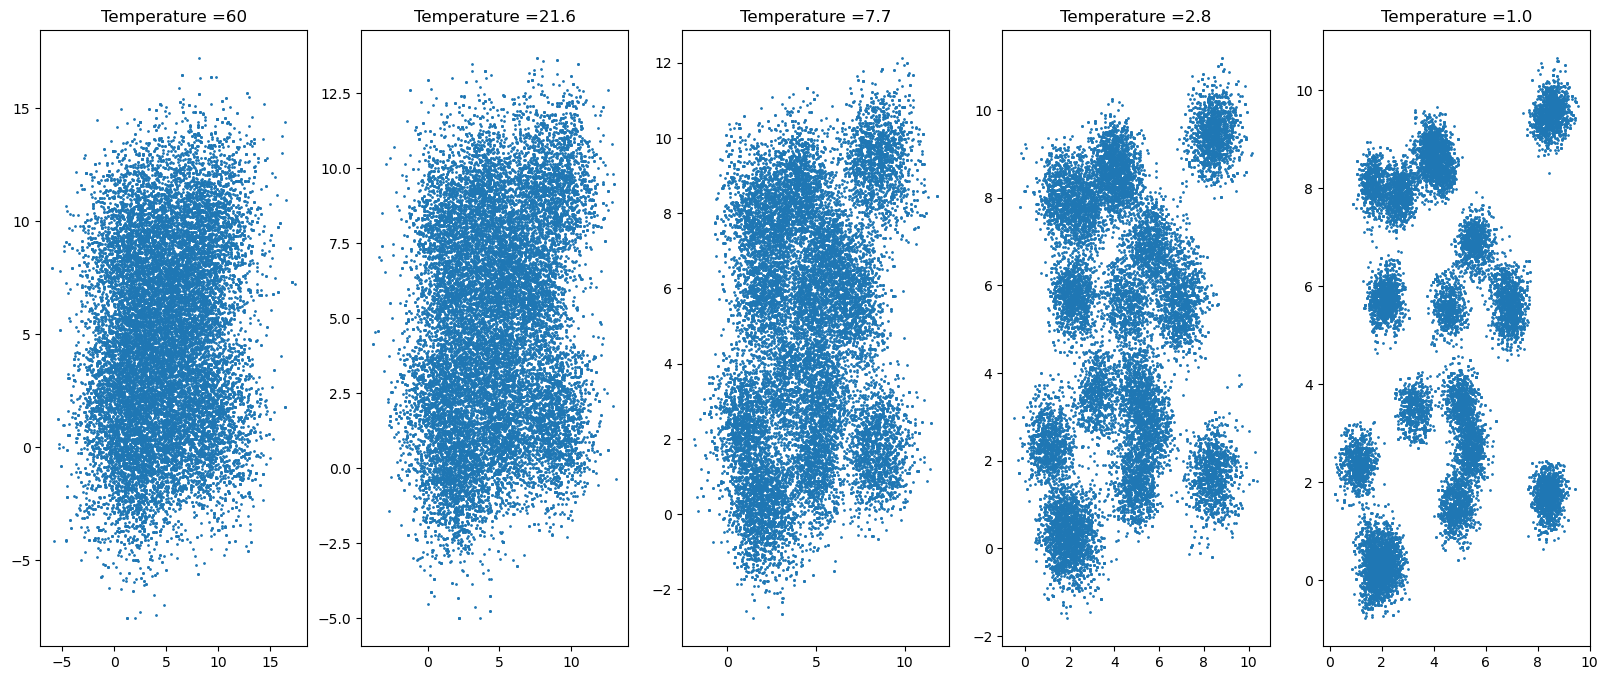

In [56]:
fig, axes = plt.subplots(1,5, figsize=(20,8))

for i in range(5):
    tempered_distribution = np.array([x[i] for x in MCchains])
    axes[i].scatter(tempered_distribution[:,0], tempered_distribution[:,1], s=1)
    axes[i].set_title('Temperature ='+str(temperatures[i]))
plt.show()

# 3 - Bayesian analysis of a one-way random effects model

## Q-1

## Q-2

In [36]:
# Conditional distributions of the parameters

def sample_sigma_square(theta, observations, alpha=1, beta=1):
    'theta : current state of the MC'
    copied = copy.deepcopy(theta)
    N = len(observations[1]) #number of random effects
    X = theta[-1]
    mu = theta[-2]
    somme = np.sum(np.square(X - mu))
    loc = N/2 + alpha
    scale = beta + somme/2
    copied[0] = invgamma.rvs(loc, scale = scale)
    return copied

def sample_tau_square(theta, observations, gamma=1, beta=1):
    'theta : current state of the MC'
    copied = copy.deepcopy(theta)
    N = len(observations[1]) #number of random effects
    K = observations[0]
    Y = observations[1]
    X = theta[-1]
    loc = K/2 + gamma
    somme = 0
    for i in range(N):
        somme += np.sum(np.square(Y[i] - X[i]))
    somme = 0.5 * somme
    scale = beta + somme
    copied[1] = invgamma.rvs(loc, scale = scale)
    return copied

def sample_mu(theta, observations):
    'theta : current state of the MC'
    copied = copy.deepcopy(theta)
    N = len(observations[1]) #number of random effects
    X = theta[-1]
    sigma_square = theta[0]
    X_bar = np.mean(X)
    var = sigma_square / N
    copied[2] = np.random.normal(X_bar, np.sqrt(var))
    return copied

def sample_X(theta, observations):
    'theta : current state of the MC'
    copied = copy.deepcopy(theta)
    N = len(observations[1]) #number of random effects
    sigma_square = theta[0]
    tau_square = theta[1]
    mu = theta[2]
    var = []
    mean = []
    
    for i in range(N):
        k_i = len(observations[1][i])
        var_i = sigma_square * tau_square / (tau_square + k_i * sigma_square)
        mean_i = var_i * (mu / sigma_square + 1 / tau_square * np.sum(observations[1][i]))
        var.append(var_i)
        mean.append(mean_i)

    var = np.array(var)
    mean = np.array(mean)
    X = np.random.multivariate_normal(mean, np.sqrt(var) * np.eye(N))
    copied[-1] = X
    return copied

In [37]:
def Gibbs_sampler(theta0, observations, N_iter):
    'Parameters : '
    'theta0 is the initial value of the parameters : sigma_square, tau_square, mu, X'
    'X is the random effects is a vector of length N'
    'observations is the list of observations Y, of length k. observation[0] stores the number of observations'
    'N_iter is the number of iterations of the algorithm'

    'Returns : '
    'a list of samples of the Markov Chain'

    liste_samples = [theta0]

    for _ in tqdm(range(N_iter)):
        buffer_theta = copy.deepcopy(liste_samples[-1])
        buffer_theta = sample_sigma_square(buffer_theta, observations)
        buffer_theta = sample_tau_square(buffer_theta, observations)
        buffer_theta = sample_mu(buffer_theta, observations)
        liste_samples.append(sample_X(buffer_theta, observations))
        
    return liste_samples

## Q-3

Now that we know the posterior distribution of $(X, \mu)$, we can implement the Gibbs block sampler : 

In [80]:
def samples_X_mu(theta, observations):
    'theta : current state of the MC'
    N = len(observations[1]) #number of random effects
    sigma_square = theta[0]
    tau_square = theta[1]

    k_i_s = np.array([len(observations[1][i]) for i in range(N)]) #number of observations for each individual
    sigma_i_s = [sigma_square * tau_square / (tau_square + k_i_s[i] * sigma_square) for i in range(N)] #variance of the conditional distribution of X_i
    sigma_i_s.append(sigma_square/N)
    sigma_i_s = np.array(sigma_i_s)
    y_i_s = [np.sum(observations[1][i]) for i in range(N)] #sum of the observations for each individual
    y_i_s.append(0)
    y_i_s = np.array(y_i_s)
    invcov = np.diag(1/sigma_i_s)
    for i in range(N+1):
        invcov[i, -1] = -1/sigma_square
        invcov[-1, i] = -1/sigma_square
    invcov[-1, -1] = N/sigma_square
    cov = np.linalg.inv(invcov)
    mean = 1/tau_square * np.matmul(cov,y_i_s)

    res = np.random.multivariate_normal(mean, cov)
    X = res[:-1]
    mu = res[-1]
    return X, mu

In [81]:
def block_Gibbs_sampler(theta0, observations, N_iter):
    """
    theta0 is the initial value of the parameters : sigma_square, tau_square, mu, X
    X is the random effects is a vector of length N
    observations is the list of observations Y, of length k. observation[0] stores the total number of observations
    N_iter is the number of iterations of the algorithm

    Returns : 
    a list of samples of the Markov Chain
    """

    liste_samples = [theta0]

    for _ in tqdm(range(N_iter)):
        buffer_theta = copy.deepcopy(liste_samples[-1])
        buffer_theta = sample_sigma_square(buffer_theta, observations)
        buffer_theta = sample_tau_square(buffer_theta, observations)
        sampleXmu = samples_X_mu(buffer_theta, observations)
        liste_samples.append([buffer_theta[0], buffer_theta[1], sampleXmu[1], sampleXmu[0]])
        
    return liste_samples

## Q-4

Block-Gibbs sampling is designed to achieve faster convergence by updating multiple variables simultaneously, rather than sequentially updating one variable at a time. This approach is particularly advantageous in high-dimensional settings where individual updates can become inefficient and slow to propagate information throughout the entire system.

In our case, the joint distribution of the block $(X, \mu)$ follows a normal distribution, which allows for efficient sampling. Since the block can be sampled directly, it provides a theoretical advantage in terms of computational speed compared to standard Gibbs sampling, where each variable is updated conditionally, one at a time.

However, this gain in sampling efficiency comes with a significant computational cost. To sample from the multivariate normal distribution of $(X, \mu)$, it is necessary to compute the inverse of a matrix, which is an expensive operation, especially as the dimensionality of the system increases.

Therefore, while the conceptual advantage of Block-Gibbs lies in its potential for faster convergence, the need to compute matrix inverses in each iteration offsets this benefit. Perhaps, we could have used approximate matrix inverses or exploited sparsity in the matrix. 

## Q-5

In [125]:
# Generation of the dataset 

alpha, beta, gamma = 1.0, 1.0, 1.0
N_x = 15
k_i = [100 for _ in range(N_x)]
K = np.sum(k_i)

ground_truth_sigma = 2
ground_truth_tau = 2
ground_truth_mu = 5

X = np.random.normal(ground_truth_mu, ground_truth_sigma, N_x)
Y = [np.random.normal(X[i], ground_truth_tau, k_i[i]) for i in range(N_x)]
observations = [K, Y]

In [126]:
sigma0 = np.random.uniform(ground_truth_sigma-1, ground_truth_sigma+1)
tau0 = np.random.uniform(ground_truth_tau-1, ground_truth_tau+1)
mu0 = np.random.uniform(ground_truth_mu-2, ground_truth_mu+2)

theta_0 = [sigma0, tau0, mu0, X]
N_iter = 70000

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


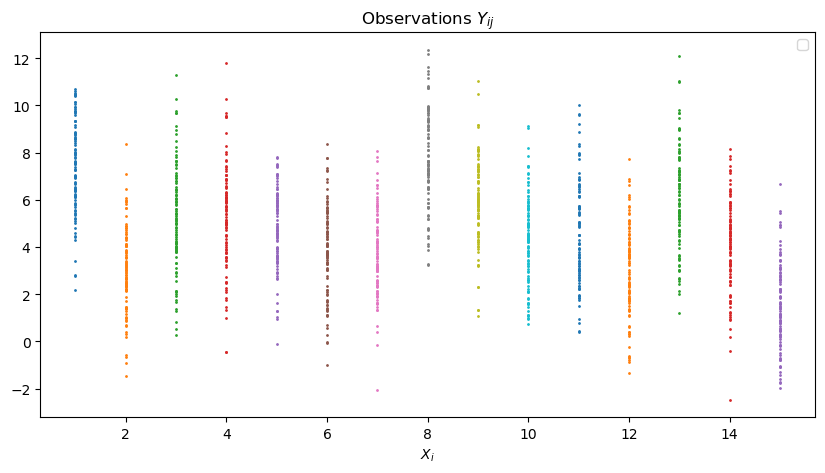

In [127]:
# plot the data
fig, axes = plt.subplots(1,1, figsize=(10,5))
for i in range(N_x):
    axes.scatter([i+1 for _ in range(k_i[i])], Y[i], s=1)

axes.set_xlabel(r'$X_i$')
axes.set_title(r'Observations $Y_{ij}$')
axes.legend()


## Comparison of the approaches

In [128]:
samples_gibbs = Gibbs_sampler(theta_0, observations, N_iter)

100%|██████████| 70000/70000 [00:10<00:00, 6646.15it/s]


In [129]:
samples_block_gibbs = block_Gibbs_sampler(theta_0, observations, N_iter)

  0%|          | 0/70000 [00:00<?, ?it/s]

100%|██████████| 70000/70000 [00:36<00:00, 1935.48it/s]


In [130]:
start = int(N_iter/3)

sigma_samples_1 = [x[0] for x in samples_gibbs[start:]]
tau_samples_1 = [x[1] for x in samples_gibbs[start:]]
mu_samples_1 = [x[2] for x in samples_gibbs[start:]]
X_samples_1 = [x[3] for x in samples_gibbs[start:]]

In [131]:
sigma_samples_2 = [x[0] for x in samples_block_gibbs[start:]]
tau_samples_2 = [x[1] for x in samples_block_gibbs[start:]]
mu_samples_2 = [x[2] for x in samples_block_gibbs[start:]]
X_samples_2 = [x[3] for x in samples_block_gibbs[start:]]

### $\sigma^2$

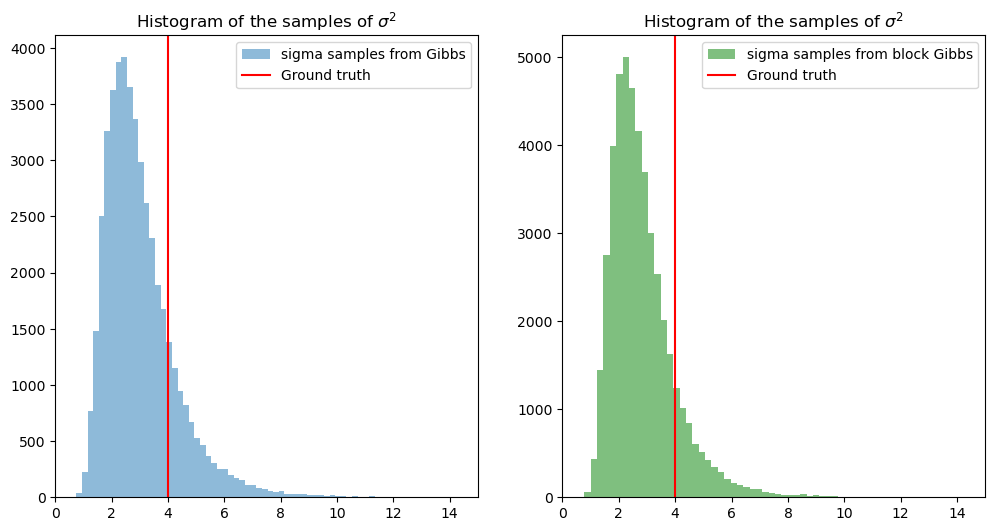

In [134]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

axes[0].hist(sigma_samples_1, bins=100, alpha=0.5, label='sigma samples from Gibbs')
axes[0].axvline(x=ground_truth_sigma**2, color='r', label='Ground truth')
axes[0].set_title(r'Histogram of the samples of $\sigma^2$')
axes[0].legend()
axes[0].set_xlim([0, 15])  # Set the x-axis limits

axes[1].hist(sigma_samples_2, bins=100, alpha=0.5, label='sigma samples from block Gibbs', color='g')
axes[1].axvline(x=ground_truth_sigma**2, color='r', label='Ground truth')
axes[1].set_title(r'Histogram of the samples of $\sigma^2$')
axes[1].legend()
axes[1].set_xlim([0, 15])  # Set the x-axis limits

plt.show()

### $\tau^2$

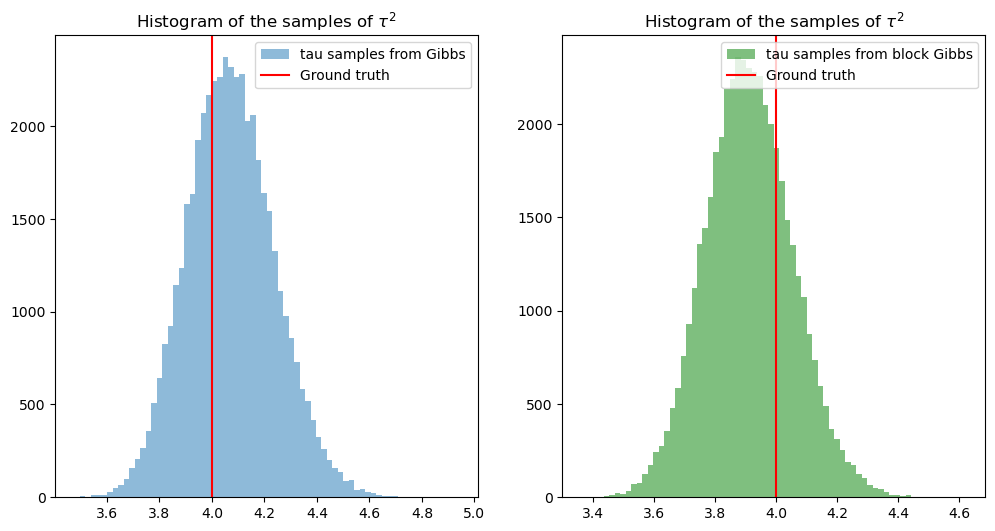

In [135]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

axes[0].hist(tau_samples_1, bins=70, alpha=0.5, label='tau samples from Gibbs')
axes[0].axvline(x=ground_truth_tau**2, color='r', label='Ground truth')
axes[0].set_title(r'Histogram of the samples of $\tau^2$')
axes[0].legend()

axes[1].hist(tau_samples_2, bins=70, alpha=0.5, label='tau samples from block Gibbs', color='g')
axes[1].axvline(x=ground_truth_tau**2, color='r', label='Ground truth')
axes[1].set_title(r'Histogram of the samples of $\tau^2$')
axes[1].legend()

plt.show()

### $\mu$

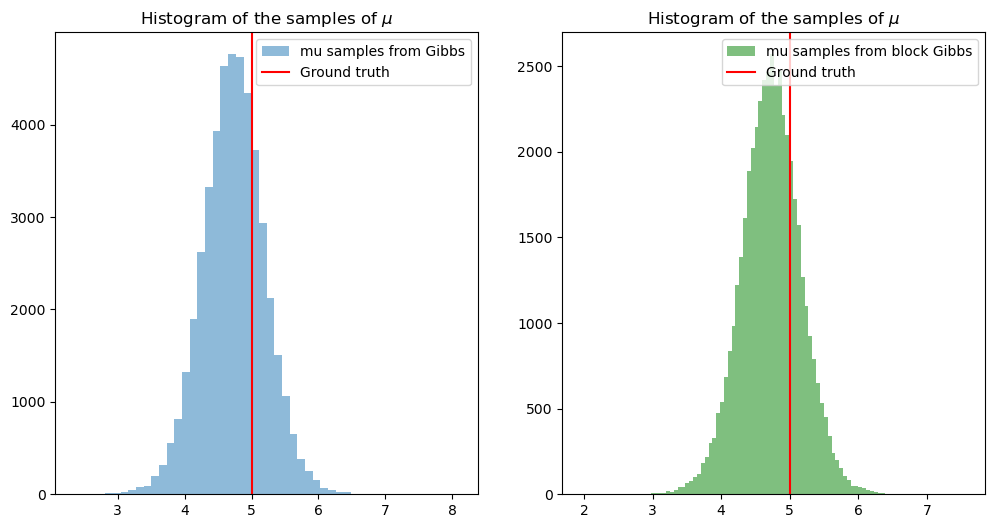

In [136]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

axes[0].hist(mu_samples_1, bins=50, alpha=0.5, label='mu samples from Gibbs')
axes[0].axvline(x=ground_truth_mu, color='r', label='Ground truth')
axes[0].set_title(r'Histogram of the samples of $\mu$')
axes[0].legend()

axes[1].hist(mu_samples_2, bins=100, alpha=0.5, label='mu samples from block Gibbs', color='g')
axes[1].axvline(x=ground_truth_mu, color='r', label='Ground truth')
axes[1].set_title(r'Histogram of the samples of $\mu$')
axes[1].legend()

plt.show()